In [53]:
import time
import numpy as np
from sklearn.datasets import make_classification, make_moons
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.metrics import accuracy_score, roc_curve, auc, ConfusionMatrixDisplay, confusion_matrix


# Generate dataset

In [72]:
X, y = make_classification( n_samples=2502, 
                            random_state=259202,
                            n_features=2, 
                            n_informative=2, 
                            n_redundant=0, 
                            n_repeated=0, 
                            class_sep=2)
Xm, ym = make_moons(n_samples=2502, random_state=259202)

In [73]:
X.shape, y.shape, Xm.shape, ym.shape

((2502, 2), (2502,), (2502, 2), (2502,))

In [74]:
def plot_data(X, y, title=""):
    sns.scatterplot(x=X[:,0], y=X[:,1], hue=y)
    plt.title(title)
    plt.show()

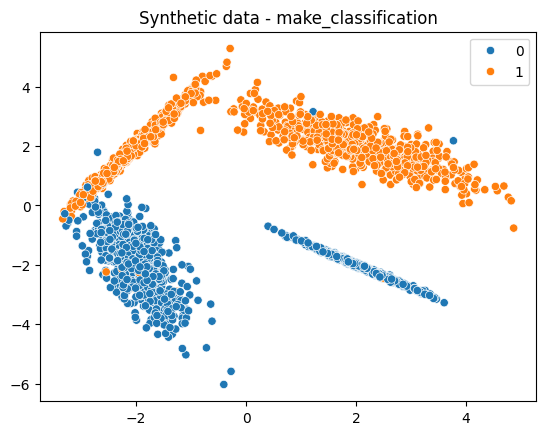

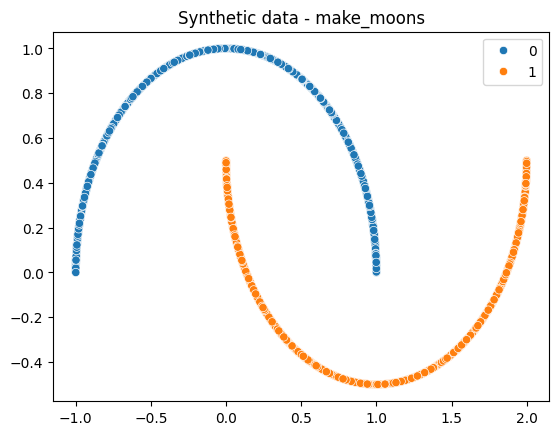

In [75]:
plot_data(X, y, "Synthetic data - make_classification")
plot_data(Xm, ym, "Synthetic data - make_moons")

In [76]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=295202)
Xm_train, Xm_test, ym_train, ym_test = train_test_split(Xm, ym, random_state=295202)

In [77]:
# scaler = StandardScaler()
# X_train = scaler.fit_transform(X_train)
# X_test = scaler.fit(X_test)

# scaler_moons = StandardScaler()
# Xm_train = scaler_moons.fit_transform(Xm_train)
# Xm_test = scaler_moons.fit(Xm_test)

In [78]:
def plot_decision_boundary_clf(X, y, clf, title=""):
    h = 0.02
    x_min, x_max = X[:,0].min() - 1, X[:,0].max() + 1
    y_min, y_max = X[:,1].min() - 1, X[:,1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    
    Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    
    plt.contourf(xx, yy, Z > 0, alpha=0.3)
        
    plt.scatter(X[:, 0], X[:, 1], c=y, edgecolors='k')
    
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.title(title)
    plt.show() 

# Sklearn SVM SVC

In [84]:
clf = make_pipeline(StandardScaler(), SVC(gamma='auto'))
clf.fit(X_train, y_train)
y_pred_skl = clf.predict(X_test)
y_score_skl = clf.decision_function(X_test)
accuracy_skl = accuracy_score(y_test, y_pred_skl)

clfm = make_pipeline(StandardScaler(), SVC(gamma='auto'))
clfm.fit(Xm_train, ym_train)
ym_pred_skl = clfm.predict(Xm_test)
ym_score_skl = clfm.decision_function(Xm_test)
accuracy_skl_moons = accuracy_score(ym_test, ym_pred_skl)

In [85]:
print(f"Accuracy score SVC - make_classification: {accuracy_skl}")
print(f"Accuracy score SVC - make_moons: {accuracy_skl_moons}")

Accuracy score SVC - make_classification: 0.9952076677316294
Accuracy score SVC - make_moons: 1.0


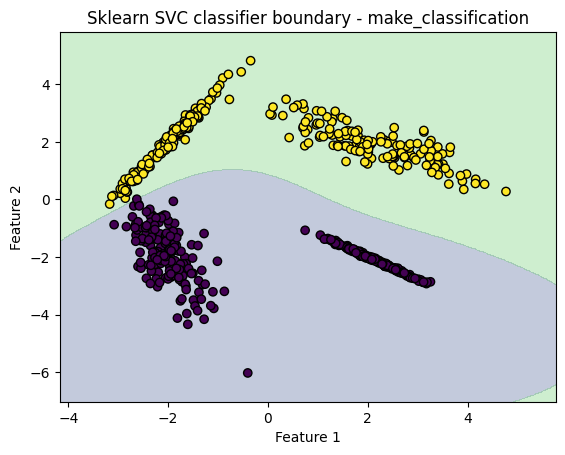

In [ ]:
plot_decision_boundary_clf(X_test, y_pred_sklean, clf, "Sklearn SVC classifier boundary - make_classification")

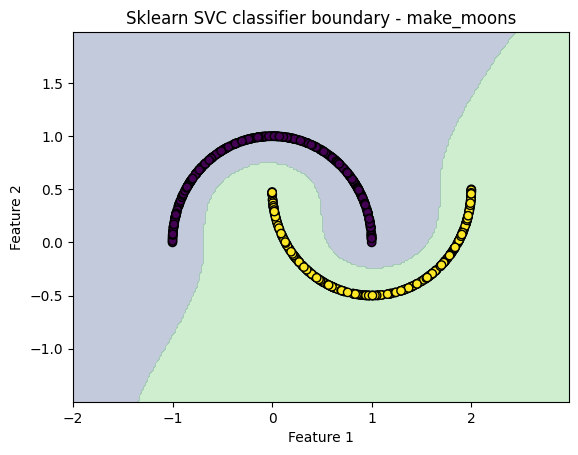

In [ ]:
plot_decision_boundary_clf(Xm_test, ym_pred_sklean, clfm, "Sklearn SVC classifier boundary - make_moons")

# Evaluation

In [ ]:
start_time = time.time()
for _ in range(10):
    clf = make_pipeline(StandardScaler(), SVC(gamma='auto'))
sklearn_time = time.time() - start_time

In [ ]:
print(f"Sklearn time: {sklearn_time:.6f} s")

Sklearn time: 0.001002 s


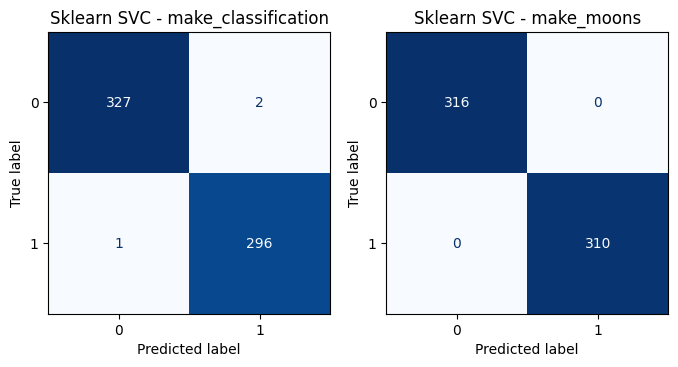

In [86]:
figure, axes = plt.subplots(1, 2, figsize=(8,10))

# make_classification dataset
cm_skl = confusion_matrix(y_test, y_pred_skl)
disp_skl = ConfusionMatrixDisplay(cm_skl)
disp_skl.plot(ax=axes[0], cmap='Blues', colorbar=None)
axes[0].set_title("Sklearn SVC - make_classification")

# make_moons dataset
cm_skl_m = confusion_matrix(ym_test, ym_pred_skl)
disp_skl_m = ConfusionMatrixDisplay(cm_skl_m)
disp_skl_m.plot(ax=axes[1], cmap='Blues', colorbar=None)
axes[1].set_title("Sklearn SVC - make_moons")

# plt.tight_layout()
plt.show()

In [89]:
name = ["Sklearn make_classification", "Sklearn moons"]
for i, cm in enumerate([cm_skl, cm_skl_m]):
    tn, fp, fn, tp = cm.ravel()
    specificity = tn / (tn+fp) # swoistosc
    sensitivity = tp / (tp+fn) # czulosc
    print(name[i])
    print(f"specificity: {specificity}")
    print(f"sensitivity: {sensitivity}\n")

Sklearn make_classification
specificity: 0.993920972644377
sensitivity: 0.9966329966329966

Sklearn moons
specificity: 1.0
sensitivity: 1.0



In [90]:
# make_classification
fpr_skl, tpr_skl, _ = roc_curve(y_test, y_score_skl)
auc_skl = auc(fpr_skl, tpr_skl)

# make_moons
fpr_skl_m, tpr_skl_m, _ = roc_curve(ym_test, ym_score_skl)
auc_skl_m = auc(fpr_skl_m, tpr_skl_m)

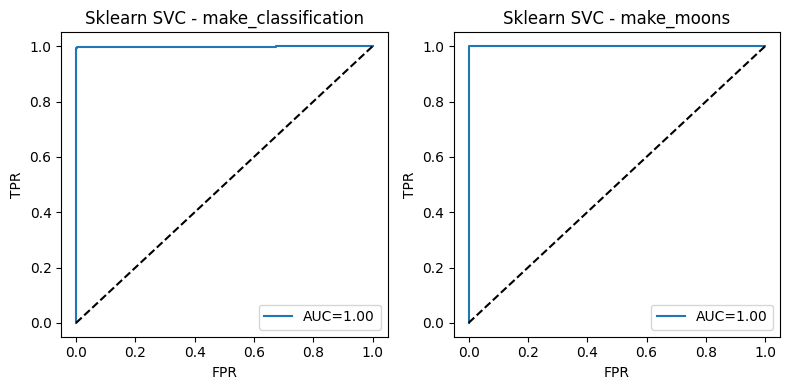

In [108]:
fig, axes = plt.subplots(1, 2, figsize=(8,4))

axes[0].plot(fpr_skl, tpr_skl, label=f"AUC={auc_skl:.2f}")
axes[0].plot([0,1],[0,1],'k--')
axes[0].set_title("Sklearn SVC - make_classification")
axes[0].set_xlabel("FPR")
axes[0].set_ylabel("TPR")
axes[0].legend(loc="lower right")

axes[1].plot(fpr_skl_m, tpr_skl_m, label=f"AUC={auc_skl_m:.2f}")
axes[1].plot([0,1],[0,1],'k--')
axes[1].set_title("Sklearn SVC - make_moons")
axes[1].set_xlabel("FPR")
axes[1].set_ylabel("TPR")
axes[1].legend(loc="lower right")

plt.tight_layout()
plt.show()